In [1]:
#!wget https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv.gz

--2026-01-22 09:34:39--  https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv.gz
Resolving static.openfoodfacts.org (static.openfoodfacts.org)... 213.36.253.214
Connecting to static.openfoodfacts.org (static.openfoodfacts.org)|213.36.253.214|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://openfoodfacts-ds.s3.eu-west-3.amazonaws.com/en.openfoodfacts.org.products.csv.gz [following]
--2026-01-22 09:34:39--  https://openfoodfacts-ds.s3.eu-west-3.amazonaws.com/en.openfoodfacts.org.products.csv.gz
Resolving openfoodfacts-ds.s3.eu-west-3.amazonaws.com (openfoodfacts-ds.s3.eu-west-3.amazonaws.com)... 3.5.206.83, 3.5.204.17
Connecting to openfoodfacts-ds.s3.eu-west-3.amazonaws.com (openfoodfacts-ds.s3.eu-west-3.amazonaws.com)|3.5.206.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1211426323 (1.1G) [application/gzip]
Saving to: ‘en.openfoodfacts.org.products.csv.gz’

en.openfoodfacts.or 100%[=====

In [2]:
import gzip
import shutil

input_gz_file = 'en.openfoodfacts.org.products.csv.gz'
output_csv_file = 'en.openfoodfacts.org.products.csv'

with gzip.open(input_gz_file, 'rb') as f_in:
    with open(output_csv_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)


In [ ]:
#!pip install pyspark -q
#!pip install findspark -q

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("TER").getOrCreate()

In [4]:
df = spark.read.option("delimiter", "\t").csv(
    'en.openfoodfacts.org.products.csv',
    header=True
)

df.show(5)

+--------+--------------------+--------------------+----------+--------------------+---------------+----------------------+----------------+--------------+---------------------+------------+------------------------+------------+--------+---------+--------------+------------+--------------+------+-----------+---------+----------+---------------+-------------+-------+------------+----------+--------------------+-------------------------+------+-----------+---------+---------+--------------+------------------------+------+-----------+---------------+------+----------+--------------+------------+----------------+----------------+-------------------------+---------+------------+------+-----------+---------+------------+----------------+-----------------+-----------+---------+--------------+------------+----------------+----------------+----------+-------------+-------------+-----------+----------------+--------------+--------------------+--------------------+--------------------+-----------

In [5]:
df.count()

4292072

In [13]:
df_sample_spark = df.sample(
    withReplacement=False,
    fraction=100_000 / 4_292_072,
    seed=42
)

In [14]:
df_pandas = df_sample_spark.toPandas()

In [15]:
df_pandas.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,last_modified_by,last_updated_t,last_updated_datetime,...,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,sulphate_100g,nitrate_100g,acidity_100g,carbohydrates-total_100g
0,00000018,http://world-en.openfoodfacts.org/product/0000...,foodvisor,1729882037,2024-10-25T18:47:17Z,1745346792,2025-04-22T18:33:12Z,roboto-app,1745346792,2025-04-22T18:33:12Z,...,None,None,None,None,None,None,None,None,None,None
1,00000110,http://world-en.openfoodfacts.org/product/0000...,vegan-app-chakib,1613694359,2021-02-19T00:25:59Z,1736849438,2025-01-14T10:10:38Z,prepperapp,1743642635,2025-04-03T01:10:35Z,...,None,None,None,None,None,None,None,None,None,None
2,00000115,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1658078674,2022-07-17T17:24:34Z,1728034989,2024-10-04T09:43:09Z,fix-code-bot,1743271727,2025-03-29T18:08:47Z,...,None,None,None,None,None,None,None,None,None,None
3,00000193,http://world-en.openfoodfacts.org/product/0000...,foodvisor,1652203279,2022-05-10T17:21:19Z,1728035159,2024-10-04T09:45:59Z,fix-code-bot,1743628926,2025-04-02T21:22:06Z,...,None,None,None,None,None,None,None,None,None,None
4,00000210,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1655409121,2022-06-16T19:52:01Z,1740180701,2025-02-21T23:31:41Z,smoothie-app,1743674682,2025-04-03T10:04:42Z,...,None,None,None,None,None,None,None,None,None,None


In [16]:
df_pandas.shape

(100111, 215)

<Axes: >

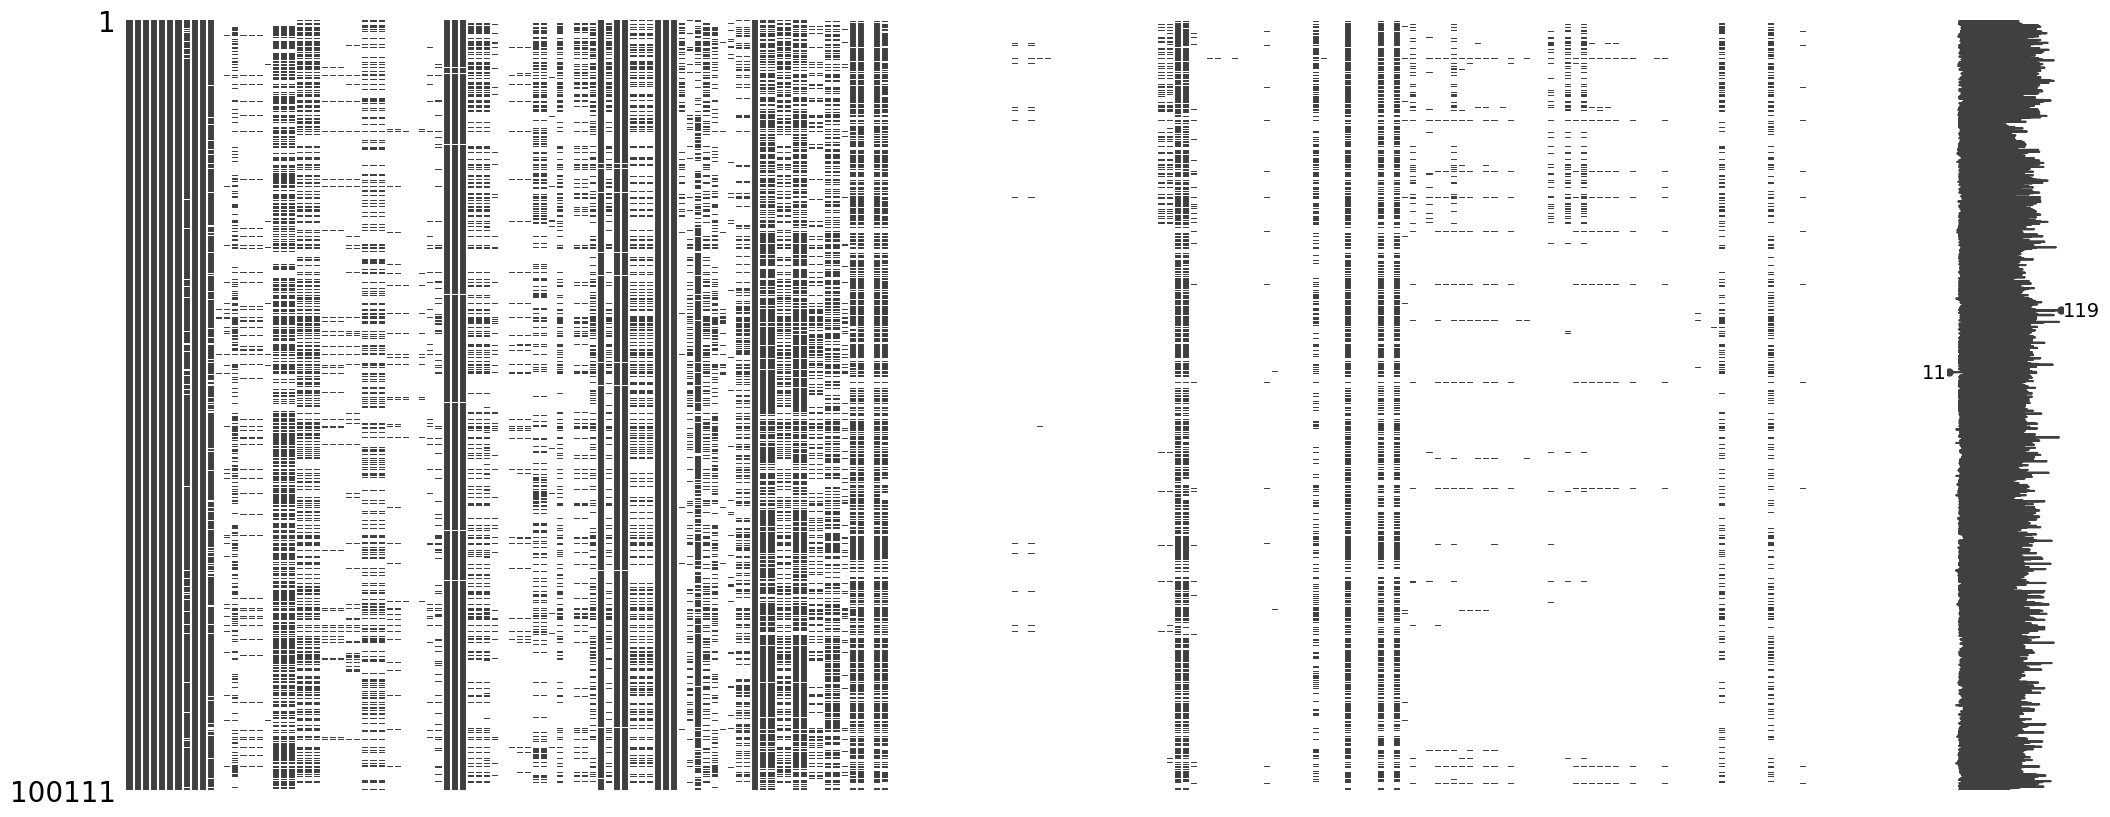

In [19]:
import missingno as msno

msno.matrix(df_pandas)

<Axes: >

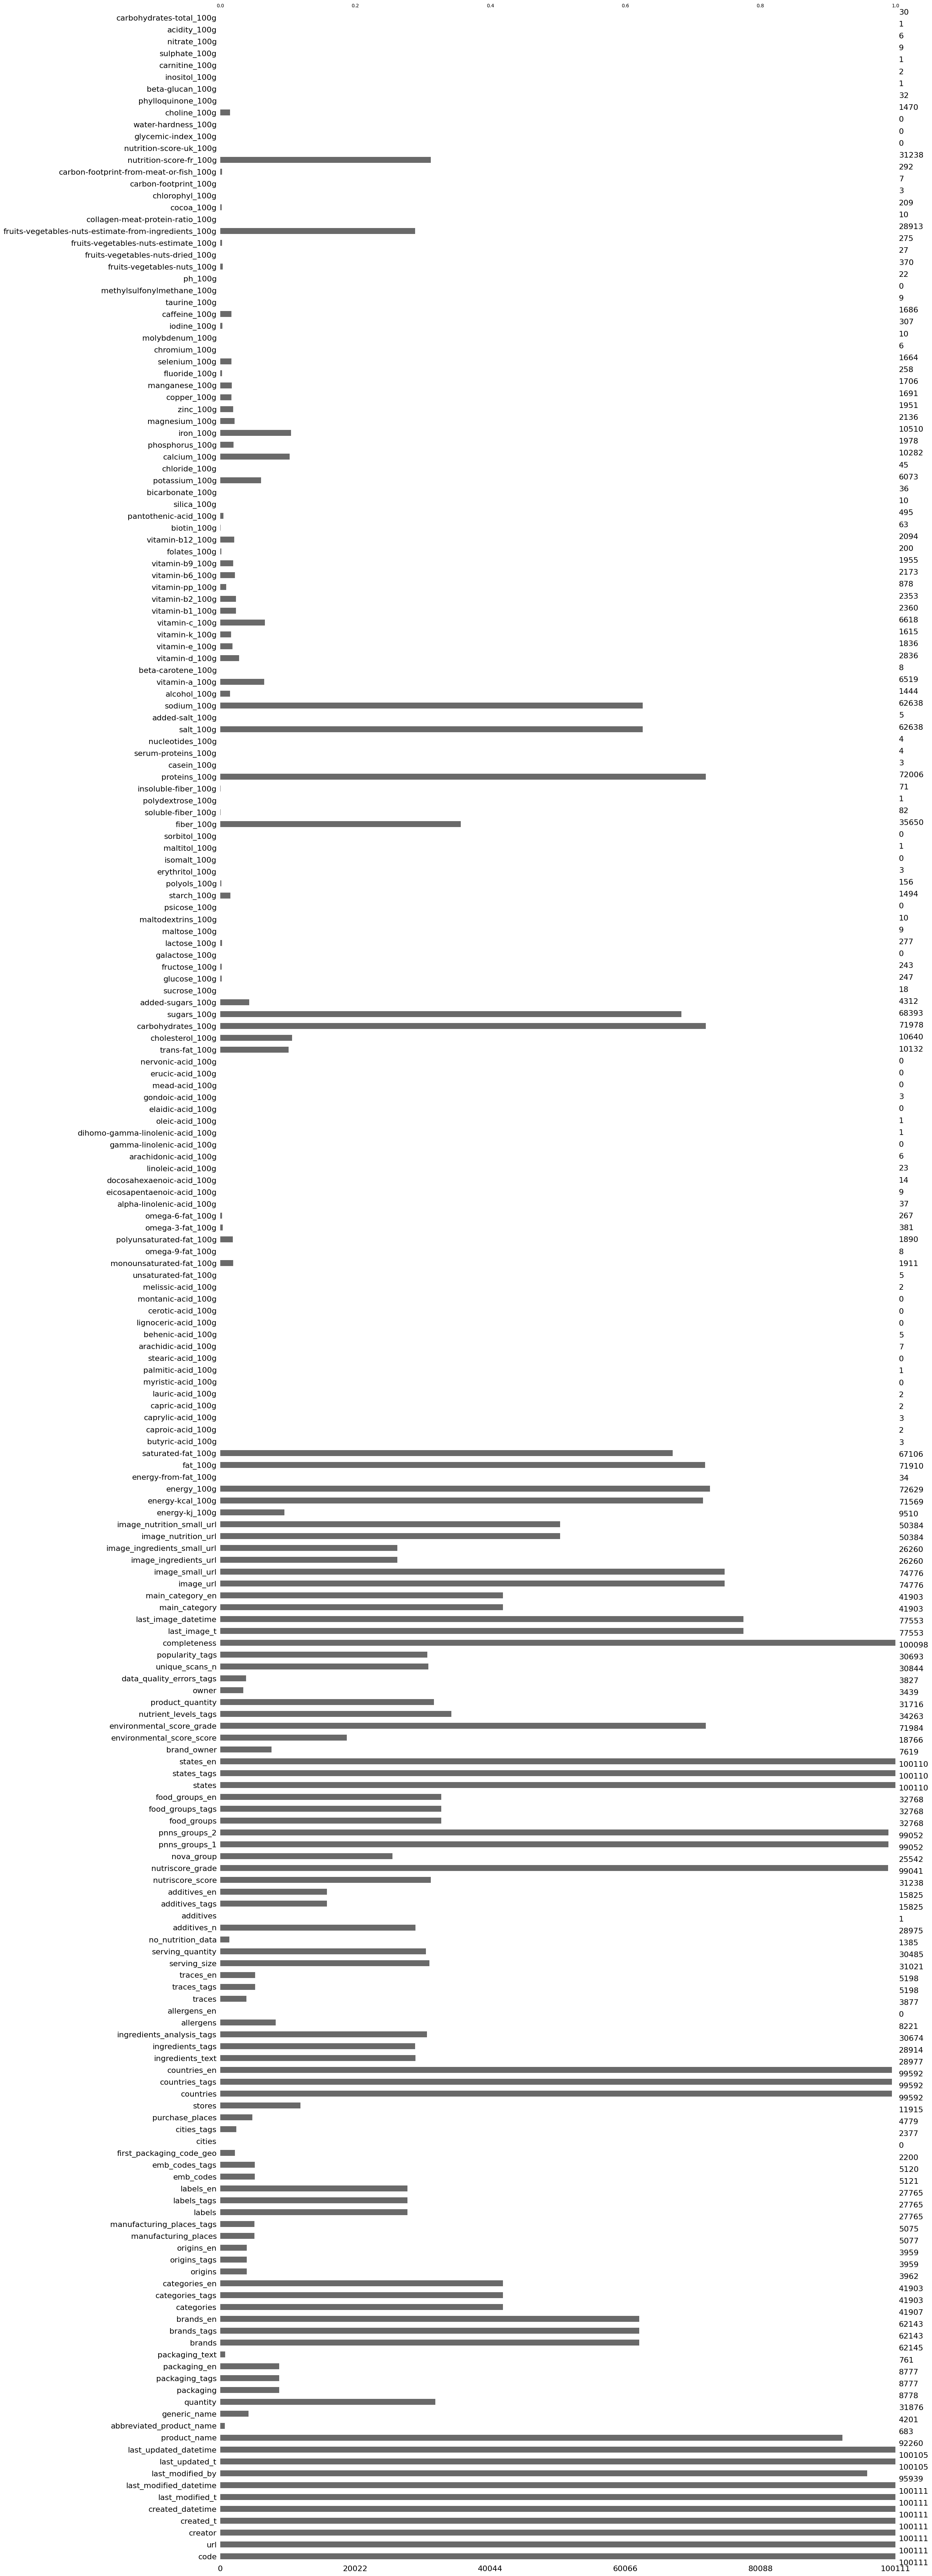

In [20]:
msno.bar(df_pandas)

In [24]:
def null_factor(datas, tx_threshold=50):
  null_rate = ((datas.isnull().sum() / datas.shape[0])*100).sort_values(ascending=False).reset_index()
  null_rate.columns = ['Variable','Taux_de_Null']
  high_null_rate = null_rate[null_rate.Taux_de_Null >= tx_threshold]
  return high_null_rate

In [25]:
full_null_rate = null_factor(df_pandas, 100)
full_null_rate

,Variable,Taux_de_Null
0,cities,100.0
1,allergens_en,100.0
2,montanic-acid_100g,100.0
3,lignoceric-acid_100g,100.0
4,cerotic-acid_100g,100.0
5,nutrition-score-uk_100g,100.0
6,methylsulfonylmethane_100g,100.0
7,glycemic-index_100g,100.0
8,water-hardness_100g,100.0
9,gamma-linolenic-acid_100g,100.0


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipython-input-4177819856.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")


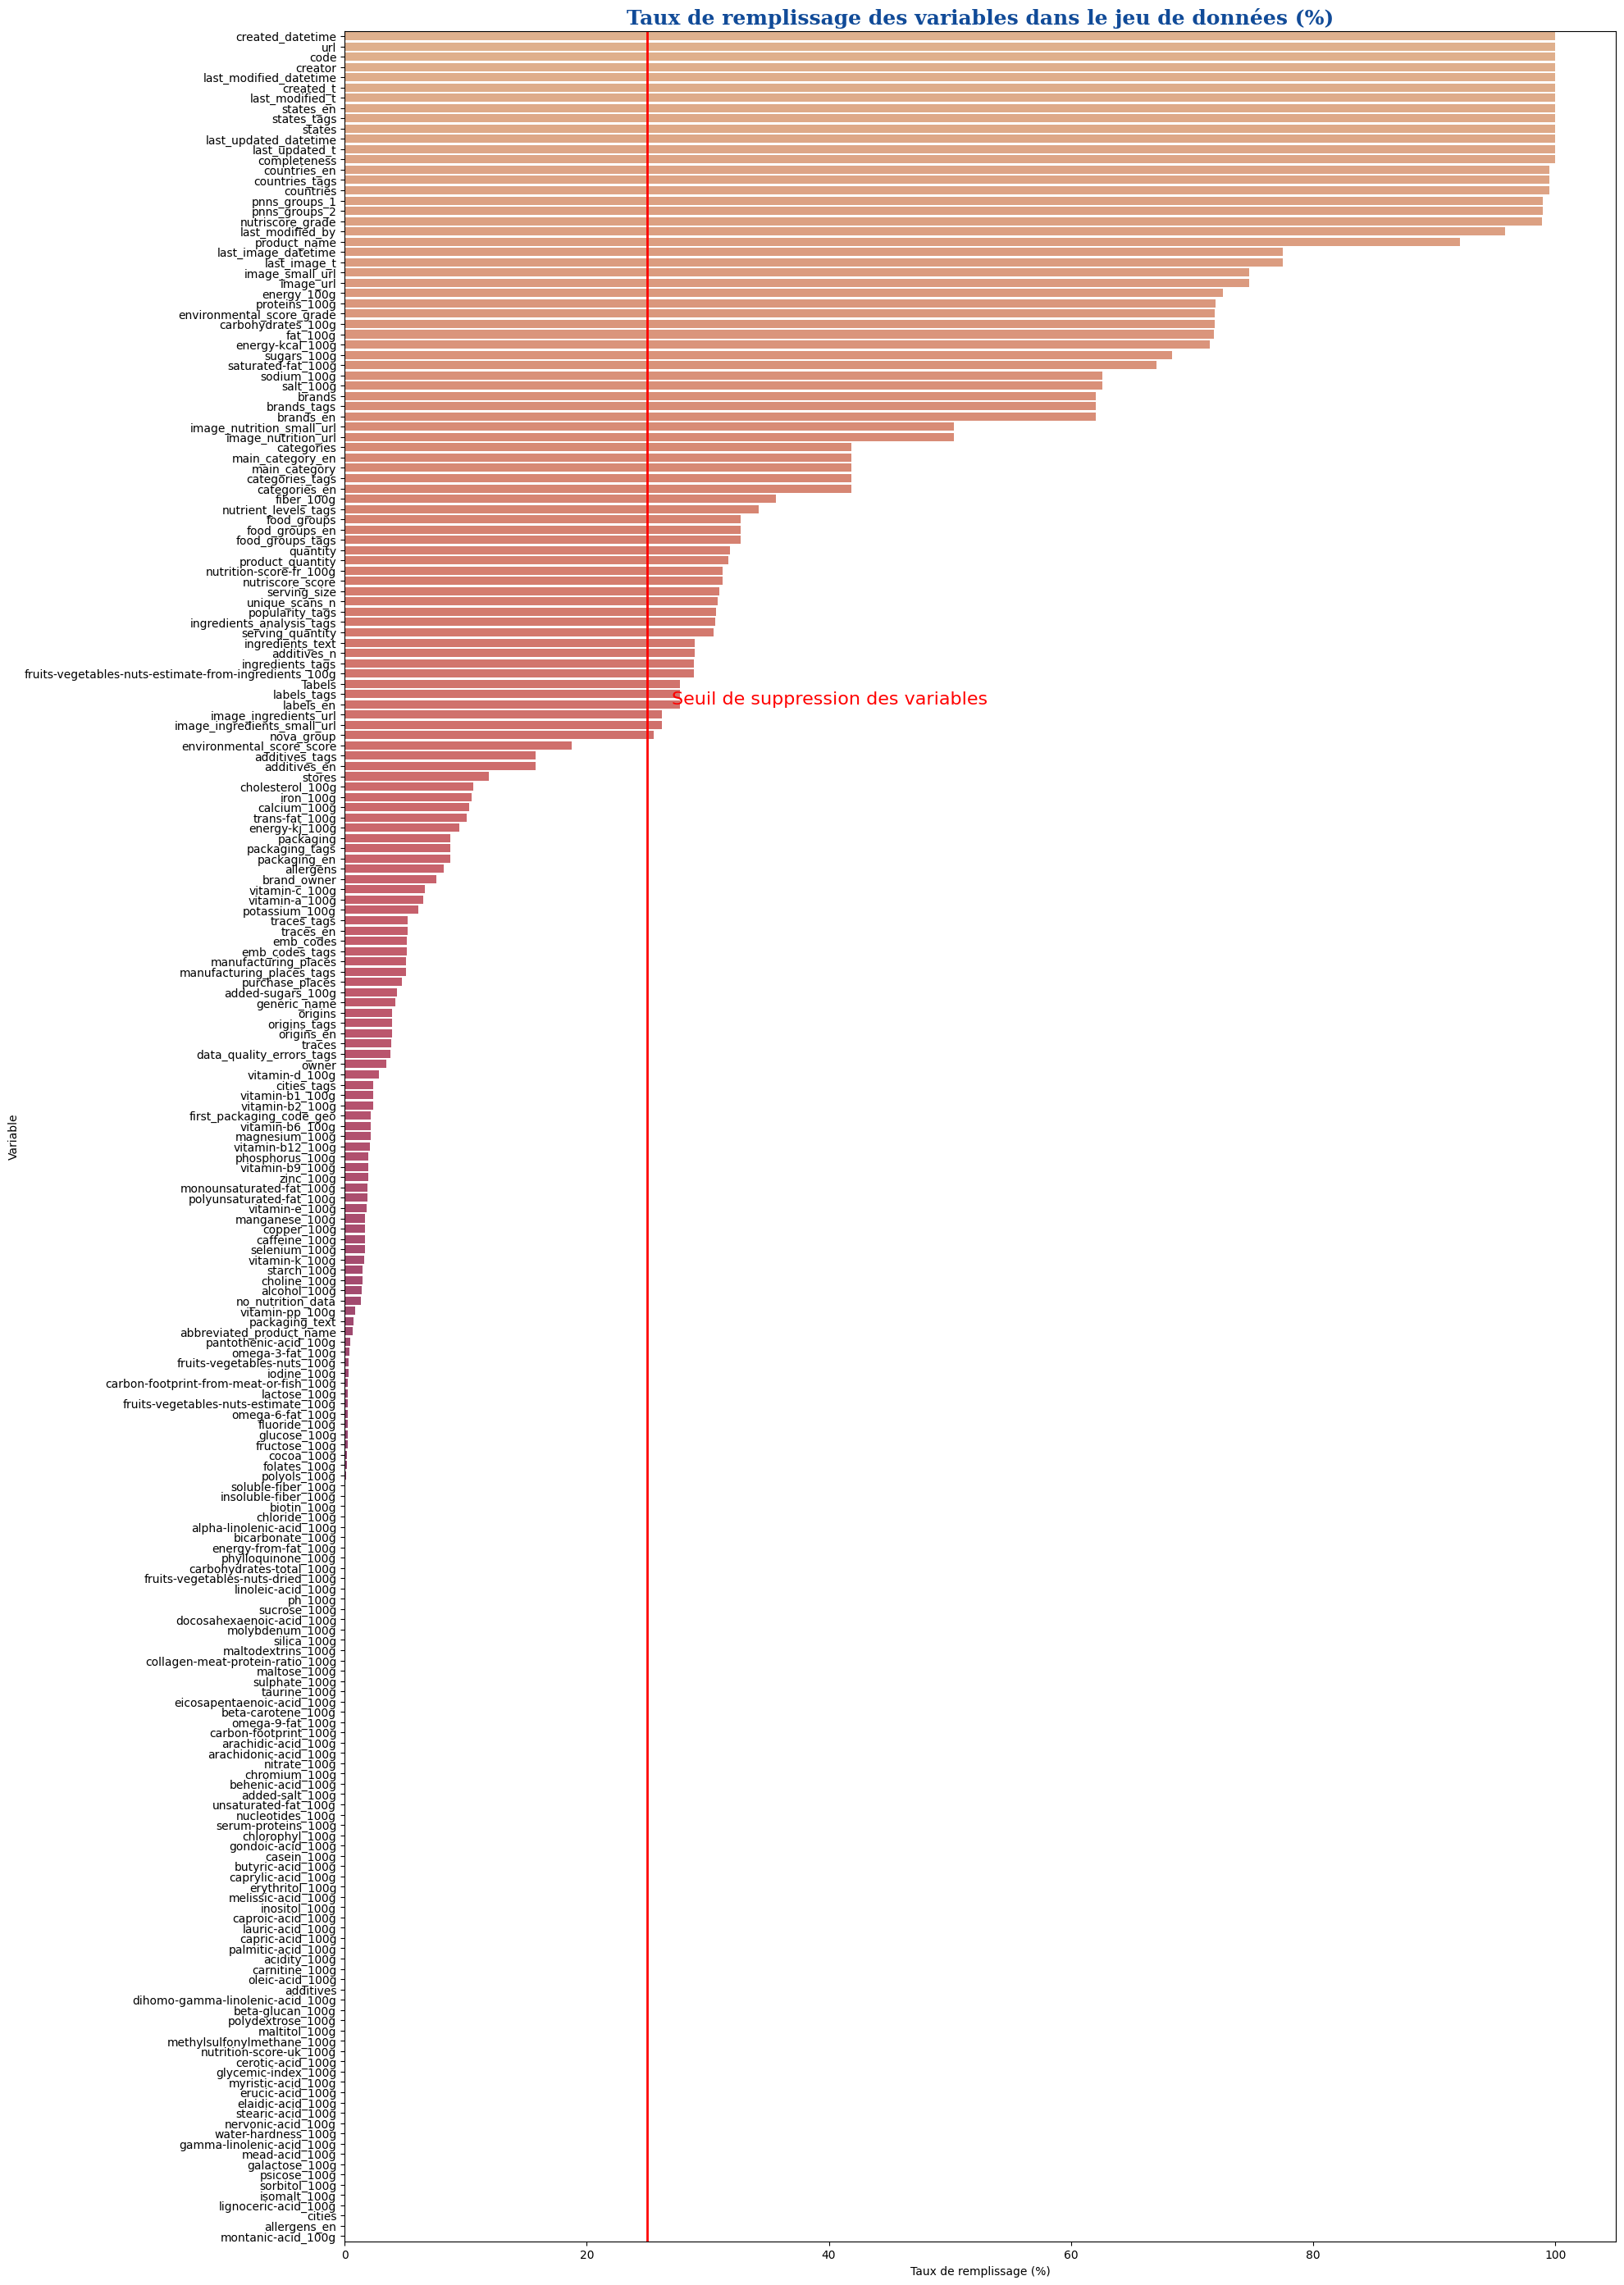

In [28]:
filling_features = null_factor(df_pandas, 0)
filling_features["Taux_de_Null"] = 100-filling_features["Taux_de_Null"]
filling_features = filling_features.sort_values("Taux_de_Null", ascending=False)

#Seuil de suppression
sup_threshold = 25

fig = plt.figure(figsize=(20, 35))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }
sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")
#Seuil pour suppression des varaibles
plt.axvline(x=sup_threshold, linewidth=2, color = 'r')
plt.text(sup_threshold+2, 65, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de remplissage des variables dans le jeu de données (%)", fontdict=font_title)
plt.xlabel("Taux de remplissage (%)")
plt.show()

In [29]:
features_to_conserve = list(
    filling_features.loc[
        filling_features['Taux_de_Null'] >= sup_threshold,
        'Variable'
    ].values
)

In [30]:
spark_cols = set(df.columns)
features_to_conserve_spark = [c for c in features_to_conserve if c in spark_cols]

In [31]:
df_sample_spark = (
    df.select(*features_to_conserve)
      .sample(withReplacement=False, fraction=1_000_000/4_292_072, seed=42)
      .limit(1_000_000)
)

In [33]:
import pandas as pd

In [34]:
df_sample_spark.write.mode("overwrite").parquet("df1_1M.parquet")

df1 = pd.read_parquet("df1_1M.parquet")


J'ai pris 1 000 000 de lignes de manière random, mais on peut reflechir sur comment on pourrait les stocker en les divisant par 4, ensuite supprime les doublons, et rassemblez enfin les 4 dataframes pour avoir un plus petit.

In [35]:
df1.head()

,created_datetime,url,code,creator,last_modified_datetime,created_t,last_modified_t,states_en,states_tags,states,...,ingredients_text,additives_n,ingredients_tags,fruits-vegetables-nuts-estimate-from-ingredients_100g,labels,labels_tags,labels_en,image_ingredients_url,image_ingredients_small_url,nova_group
0,2023-03-02T12:50:47Z,http://world-en.openfoodfacts.org/product/0000...,00000009,prepperapp,2024-10-03T19:06:33Z,1677761447,1727982393,"To be completed,Nutrition facts to be complete...","en:to-be-completed,en:nutrition-facts-to-be-co...","en:to-be-completed, en:nutrition-facts-to-be-c...",...,None,None,None,None,None,None,None,None,None,None
1,2024-10-25T18:47:17Z,http://world-en.openfoodfacts.org/product/0000...,00000018,foodvisor,2025-04-22T18:33:12Z,1729882037,1745346792,"To be completed,Nutrition facts completed,Ingr...","en:to-be-completed,en:nutrition-facts-complete...","en:to-be-completed, en:nutrition-facts-complet...",...,None,None,None,None,en:nutriscore,en:nutriscore,Nutriscore,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,None
2,2018-09-14T13:14:06Z,http://world-en.openfoodfacts.org/product/0000...,00000020,openfoodfacts-contributors,2025-06-16T14:42:01Z,1536930846,1750084921,"To be completed,Nutrition facts completed,Ingr...","en:to-be-completed,en:nutrition-facts-complete...","en:to-be-completed, en:nutrition-facts-complet...",...,"Nuts (Peanuts, Almonds), Prebiotic Blend (Tapi...",0,"en:nut,en:prebiotic-blend,en:protein-blend,en:...",56.3461538461538,"No gluten, Organic, Free range, Kosher, No pre...","en:no-gluten,en:organic,en:free-range,en:koshe...","No gluten,Organic,Free range,Kosher,No preserv...",https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,4
3,2021-07-19T13:06:17Z,http://world-en.openfoodfacts.org/product/0000...,00000028,openfoodfacts-contributors,2025-05-03T02:50:46Z,1626699977,1746240646,"To be completed,Nutrition facts completed,Ingr...","en:to-be-completed,en:nutrition-facts-complete...","en:to-be-completed, en:nutrition-facts-complet...",...,Organic Defatted Hemp Seed Powder. Certified O...,0,"en:hemp-seed,en:seed,en:by-quality-assurance-i...",0,Organic hemp protein,en:organic-hemp-protein,Organic-hemp-protein,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,1
4,2018-09-14T17:23:08Z,http://world-en.openfoodfacts.org/product/0000...,00000034,openfoodfacts-contributors,2025-05-28T01:15:13Z,1536945788,1748394913,"To be completed,Nutrition facts completed,Ingr...","en:to-be-completed,en:nutrition-facts-complete...","en:to-be-completed, en:nutrition-facts-complet...",...,Graines de chia,0,"en:chia-seed,en:seed,en:chia",0,"Sans gluten, Bio, Végétarien, Bio européen, Ag...","en:no-gluten,en:organic,en:vegetarian,en:eu-or...","No gluten,Organic,Vegetarian,EU Organic,Non-EU...",https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,1


In [36]:
df1.shape

(1000000, 69)

<Axes: >

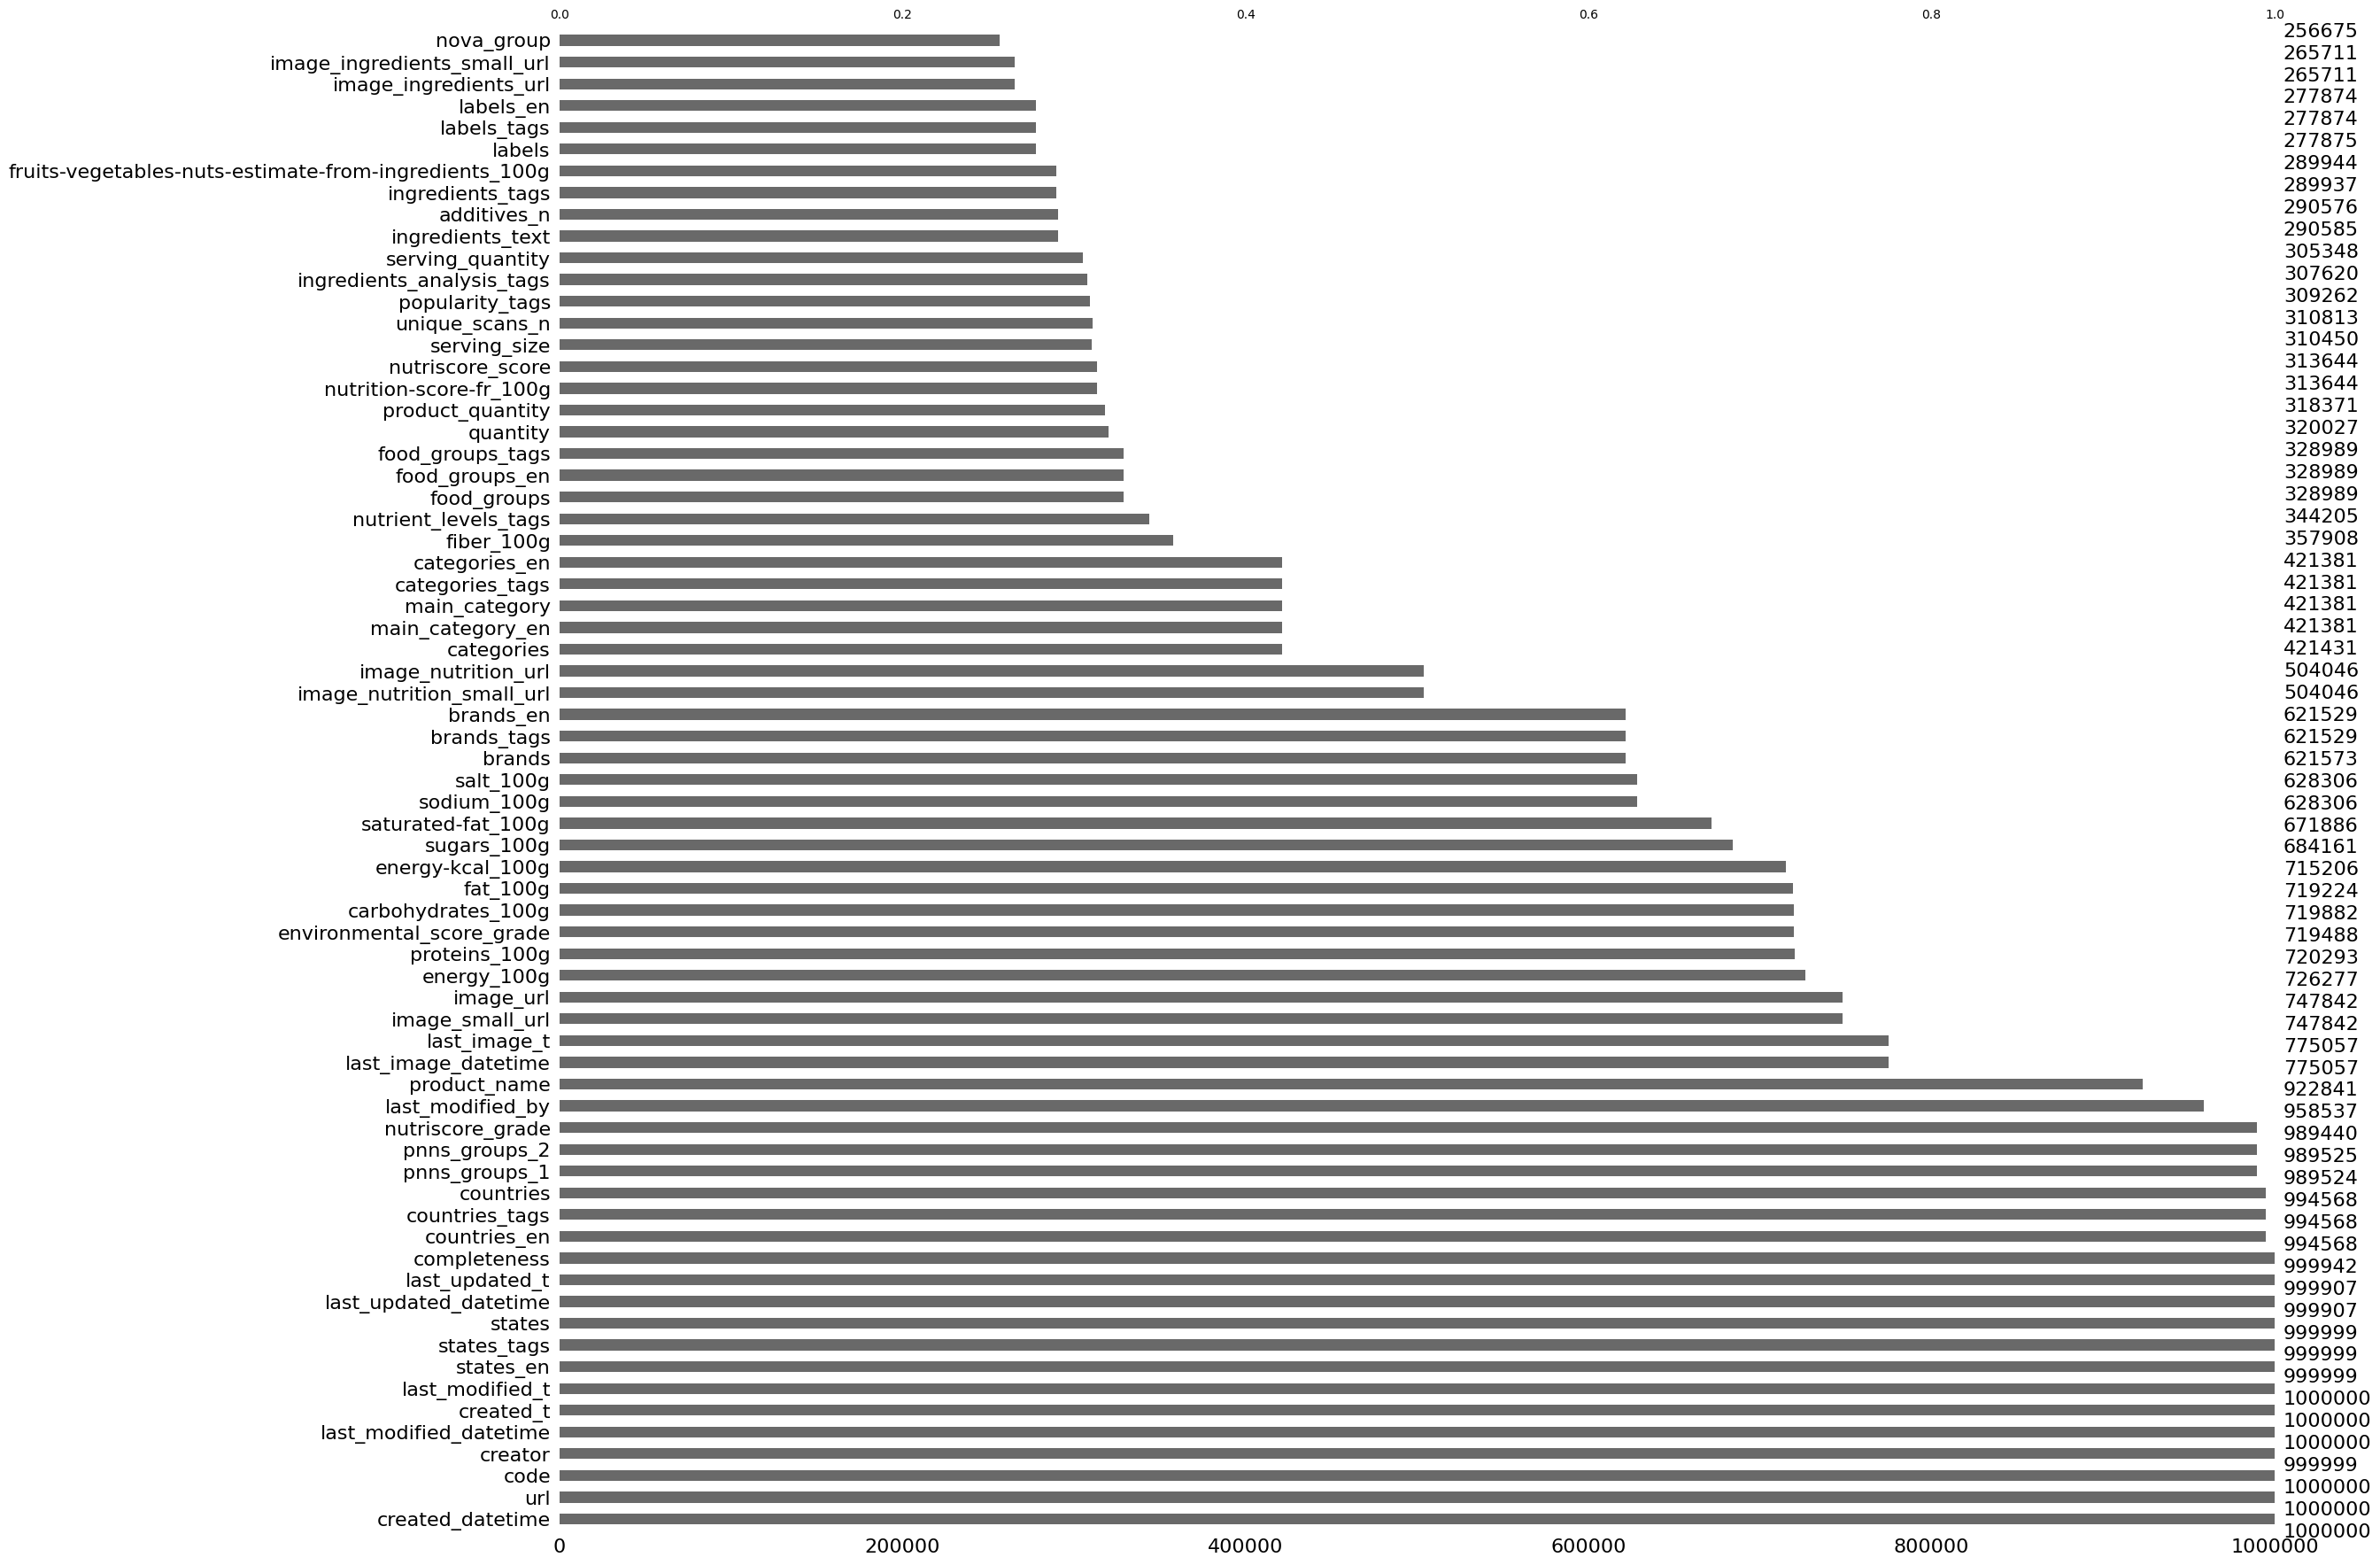

In [37]:
msno.bar(df1)